In [1]:
# write svm for classification using joint_angles_per_image.csv file
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Load the CSV file
df = pd.read_csv("joint_angles_and_distances_per_image.csv")

# Display the first few rows of the dataframe
df.head()


,Image,Left Shoulder-Left Elbow-Left Wrist,Right Shoulder-Right Elbow-Right Wrist,Left Shoulder-Left Hip-Left Knee,Right Shoulder-Right Hip-Right Knee,Left Elbow-Left Shoulder-Left Hip,Right Elbow-Right Shoulder-Right Hip,Left Hip-Left Knee-Left Ankle,Right Hip-Right Knee-Right Ankle,Nose-Left Eye_distance,...,Right Hip-Right Knee_distance,Right Hip-Left Ankle_distance,Right Hip-Right Ankle_distance,Left Knee-Right Knee_distance,Left Knee-Left Ankle_distance,Left Knee-Right Ankle_distance,Right Knee-Left Ankle_distance,Right Knee-Right Ankle_distance,Left Ankle-Right Ankle_distance,Label
0,3,176.863623,NaN,104.651653,122.947312,65.335370,NaN,32.463845,49.454794,0.000000,...,88.314888,507.562256,507.562256,459.169800,970.111694,970.111694,560.514954,560.514954,0.000000,push up
1,4,46.826189,69.684937,168.525943,175.557773,1.661186,18.735911,171.895412,169.079502,1161.640015,...,190.953522,322.854370,364.778778,15.435086,151.189606,190.094208,136.057251,175.485016,44.473217,push up
2,5,54.110698,73.605964,169.050747,177.224694,8.860401,14.912523,171.601208,166.037965,1154.134033,...,199.892090,331.824677,372.303131,17.369181,155.162338,192.347153,138.578232,175.179535,44.275284,push up
3,6,73.103679,79.956933,169.036226,178.504071,10.210434,9.026413,170.603113,165.024651,1141.828735,...,211.375519,332.225159,378.802582,27.071579,153.503098,195.950623,130.737625,170.647415,53.087975,push up
4,7,88.872161,82.650630,179.723765,172.554238,24.492551,0.515483,156.767759,151.040331,1130.589844,...,208.719391,306.946991,364.712311,29.945557,139.762482,197.712402,109.817444,167.809647,58.651814,push up


In [2]:
df.shape

(11493, 146)

In [3]:

df.isnull().sum().sort_values(ascending=False)

Left Hip-Left Knee-Left Ankle             2964
Right Hip-Right Knee-Right Ankle          2773
Right Shoulder-Right Hip-Right Knee        844
Left Shoulder-Left Hip-Left Knee           843
Right Shoulder-Right Elbow-Right Wrist     771
                                          ... 
Right Eye-Right Wrist_distance               0
Right Eye-Left Wrist_distance                0
Right Eye-Right Elbow_distance               0
Right Eye-Left Elbow_distance                0
Label                                        0
Length: 146, dtype: int64

In [4]:
# print dropped columns 

dropped_columns = df.columns[df.isnull().sum() > 0]
print(f"Dropped columns: {dropped_columns}")

Dropped columns: Index(['Left Shoulder-Left Elbow-Left Wrist',
       'Right Shoulder-Right Elbow-Right Wrist',
       'Left Shoulder-Left Hip-Left Knee',
       'Right Shoulder-Right Hip-Right Knee',
       'Left Elbow-Left Shoulder-Left Hip',
       'Right Elbow-Right Shoulder-Right Hip', 'Left Hip-Left Knee-Left Ankle',
       'Right Hip-Right Knee-Right Ankle'],
      dtype='object')


In [5]:
# drop nan columns
df = df.dropna(axis=1)


In [6]:
df.shape

(11493, 138)

In [7]:
df.isnull().sum().sum()

0

In [8]:
# Split the data into features (X) and labels (y)
X = df.drop(columns=["Image", "Label"])  # Features
y = df["Label"]  # Labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# decision tree
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

Decision Tree accuracy: 0.98
              precision    recall  f1-score   support

 bench press       0.96      0.91      0.93       227
 hammer curl       0.96      0.99      0.98       357
lat pulldown       0.98      0.99      0.98       550
       plank       0.96      0.98      0.97       304
     push up       0.99      0.98      0.98       861

    accuracy                           0.98      2299
   macro avg       0.97      0.97      0.97      2299
weighted avg       0.98      0.98      0.98      2299



In [10]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))


Random Forest accuracy: 0.99
              precision    recall  f1-score   support

 bench press       0.99      0.98      0.98       227
 hammer curl       1.00      1.00      1.00       357
lat pulldown       0.99      1.00      0.99       550
       plank       0.99      0.99      0.99       304
     push up       1.00      0.99      1.00       861

    accuracy                           0.99      2299
   macro avg       0.99      0.99      0.99      2299
weighted avg       0.99      0.99      0.99      2299



In [ ]:
import torch
import math
import os

# Function to calculate angle between three points (p1, p2, p3)
def calculate_angle(p1, p2, p3):
    v1 = p1 - p2
    v2 = p3 - p2
    dot_product = torch.dot(v1, v2)
    magnitude_v1 = torch.norm(v1)
    magnitude_v2 = torch.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return None
    
    angle_rad = torch.acos(dot_product / (magnitude_v1 * magnitude_v2))
    return math.degrees(angle_rad.item())

# Function to calculate Euclidean distance between two points (p1, p2)
def calculate_distance(p1, p2):
    return torch.norm(p1 - p2).item()


def preprocess_and_create_dataframe(results):
    """
    Preprocess keypoints from YOLO results to calculate angles and distances and return as a DataFrame.
    :param results: Keypoints detection results from the model.
    :return: DataFrame containing features for each image.
    """

    # Joint labels for reference
    joint_labels = ["Nose", "Left Eye", "Right Eye", "Left Ear", "Right Ear",
                    "Left Shoulder", "Right Shoulder", "Left Elbow", "Right Elbow",
                    "Left Wrist", "Right Wrist", "Left Hip", "Right Hip",
                    "Left Knee", "Right Knee", "Left Ankle", "Right Ankle"]
    
    
    # Define joint triplets for angle calculations
    joint_triplets = [
        (5, 7, 9),  # Left Elbow
        (6, 8, 10), # Right Elbow
        (5, 11, 13),# Left Hip
        (6, 12, 14),# Right Hip
        (7, 5, 11), # Left Shoulder
        (8, 6, 12), # Right Shoulder
        (11, 13, 15),# Left Knee
        (12, 14, 16) # Right Knee
    ]

    processed_features = []
    
    for img_idx in range(len(results)):
        if len(results[img_idx]) == 0:
            print(f"No keypoints detected in image {img_idx + 1}")
            continue
        if len(results[img_idx]) > 1:
            print(f"Multiple detections in image {img_idx + 1}")
            results[img_idx] = results[img_idx][0]

        
        image_features = {"Image": img_idx + 1}
        
        # Calculate angles for each joint triplet
        for triplet in joint_triplets:
            p1 = results[img_idx].keypoints.xy[0][triplet[0]]
            p2 = results[img_idx].keypoints.xy[0][triplet[1]]
            p3 = results[img_idx].keypoints.xy[0][triplet[2]]
            angle = calculate_angle(p1, p2, p3)
            image_features[f"{joint_labels[triplet[0]]}-{joint_labels[triplet[1]]}-{joint_labels[triplet[2]]}"] = angle
        
        # Calculate distances between all joint pairs
        num_joints = len(results[img_idx].keypoints.xy[0])
        for i in range(num_joints):
            for j in range(i + 1, num_joints):
                p1 = results[img_idx].keypoints.xy[0][i]
                p2 = results[img_idx].keypoints.xy[0][j]
                distance = calculate_distance(p1, p2)
                image_features[f"{joint_labels[i]}-{joint_labels[j]}_distance"] = distance

        
        #add the positions of the joints
        for i in range(len(results[img_idx].keypoints.xy[0])):
            p1 = results[img_idx].keypoints.xy[0][i]
            image_features[f"{joint_labels[i]}_position_y"] = p1[1]

            # to detect the position of the joint in the image
        
        processed_features.append(image_features)
    
    # Convert the list of dictionaries to a DataFrame
    return pd.DataFrame(processed_features)

def preprocess(results):
    

    df = preprocess_and_create_dataframe(results)

    print(df.shape)

    to_be_dropped = ['Left Shoulder-Left Elbow-Left Wrist',
       'Right Shoulder-Right Elbow-Right Wrist',
       'Left Shoulder-Left Hip-Left Knee',
       'Right Shoulder-Right Hip-Right Knee',
       'Left Elbow-Left Shoulder-Left Hip',
       'Right Elbow-Right Shoulder-Right Hip', 'Left Hip-Left Knee-Left Ankle',
       'Right Hip-Right Knee-Right Ankle', 'Image']
    
    df = df.drop(columns=to_be_dropped,axis=1)
    return df


In [53]:
def make_prediction(image_path, classfier_model):
    from ultralytics import YOLO
    model = YOLO("yolo11x-pose.pt")
    model.to("cuda:0")
    validation_result = model.predict(
        image_path,
        save=True,
        imgsz=320,
        conf=0.5,
        device="cuda:0"  # Use 'cuda:0' or other valid GPU index
    )
    print(validation_result[0].probs)
    

    validation_df = preprocess(validation_result)

    label = classfier_model.predict(validation_df)
    return label
    

In [54]:

prediction = make_prediction("validation_images/Ekran görüntüsü 2024-12-10 013356.png",clf)


image 1/1 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_images\Ekran grnts 2024-12-10 013356.png: 320x224 1 person, 75.0ms
Speed: 2.0ms preprocess, 75.0ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 224)
Results saved to runs\pose\predict22
None
(1, 145)


In [ ]:
# show the image 
def show_image(image_path):

    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg

    img = mpimg.imread(image_path)
    imgplot = plt.imshow(img)
    plt.show()
        


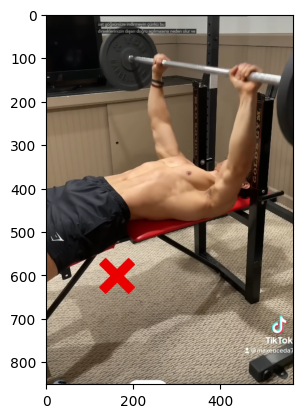

Prediction: bench press


In [56]:
show_image("validation_images/Ekran görüntüsü 2024-12-10 013356.png")
print(f"Prediction: {prediction[0]}")


image 1/1 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_images\Ekran grnts 2024-12-10 103836.png: 160x320 2 persons, 58.0ms
Speed: 1.0ms preprocess, 58.0ms inference, 2.0ms postprocess per image at shape (1, 3, 160, 320)
Results saved to runs\pose\predict23
None
Multiple detections in image 1
(1, 145)


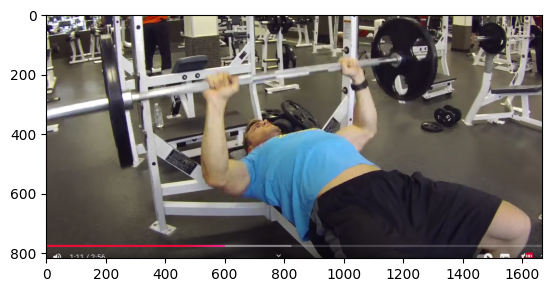

Prediction: lat pulldown


In [57]:
prediction = make_prediction("validation_images/Ekran görüntüsü 2024-12-10 103836.png",clf)
show_image("validation_images/Ekran görüntüsü 2024-12-10 103836.png")
print(f"Prediction: {prediction[0]}")


image 1/1 c:\Users\Samet\Desktop\3. Grade 1. Term\AIN 311 - 313\project\yolo model\validation_images\image.png: 320x224 1 person, 74.0ms
Speed: 1.0ms preprocess, 74.0ms inference, 3.0ms postprocess per image at shape (1, 3, 320, 224)
Results saved to runs\pose\predict25
None
(1, 145)


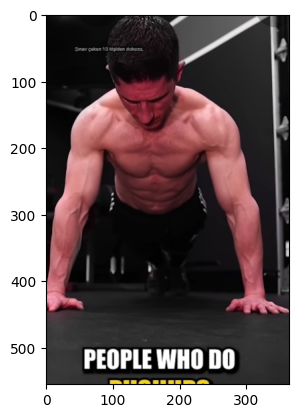

Prediction: push up


In [59]:
prediction = make_prediction("validation_images/image.png",clf)
show_image("validation_images/image.png")
print(f"Prediction: {prediction[0]}")